In [10]:
import sys
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Bernoulli, Normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import gymnasium as gym

from PIL import Image

from time import sleep

from pathlib import Path


# code for the only two actions in Pong
# 2 -> UP, 3 -> DOWN
ACTIONS = [2, 3]

In [11]:
cd /content/drive/MyDrive/RLProject2023

/content/drive/MyDrive/RLProject2023


## Helper Functions

In [51]:
def discount_rewards(reward):
    # Compute the gamma-discounted rewards over an episode
    gamma = 0.99    # discount rate
    running_add = 0
    discounted_r = torch.zeros_like(reward)

    for i in reversed(range(0, len(reward))):
        if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
            running_add = 0
        running_add = running_add * gamma + reward[i]
        discounted_r[i] = running_add

    discounted_r -= torch.mean(discounted_r) # normalizing the result
    discounted_r /= torch.std(discounted_r) # divide by standard deviation
    return discounted_r


def log(filename, string):
    with open(filename, 'a+') as logger:
        logger.write(string)

def update_demand(pt, at):
    '''
    Parameters:
    pt - Number of passengers who want to go from zone i to j - NxN matrix in timepoint t 
    new_pt - New Demand generated for timepoint t+1 - NxN matrix 
    at - Agents action, cabs displaced to satisfy demand from zone i to j - NxN matrix 
    
    Returns: 
    unsatisfied_pt - Unsatisfied demand to be carried forward  
    '''
    unsatisfied_pt = pt - at 
    unsatisfied_pt[unsatisfied_pt<0] = 0 
    
    return unsatisfied_pt

def update_supply(pt,vt, frozen, times, at):
    '''
    Parameters: 
    vt - Number of empty vehicles in each zone at time t - Nx1 vector 
    frozen - Nxt matrix with rows as destination and columns as remaining timesteps of journey 
        fjk: the number of cabs on a journey with destination j and timepoint k remaining 
    times - NxN matrix of time a trip from i to j will take 
    at - Agents action, cabs displaced to satisfy demand from zone i to j - NxN matrix
    
    Returns: 
    vt_next - Number of empty vehicles in each zone at time t+1 
    frozen_next - Updated frozen vehicle matrix 
    '''
    num_zones = frozen.shape[0]
    extra_vt = at - pt 
    extra_vt[extra_vt<0]=0
    extra_vt = np.sum(extra_vt, axis = 1) 

    for i in range(num_zones):
        for j in range(num_zones):
            frozen[j, times[i,j]-1] = at[i,j]
    return extra_vt, frozen


def get_reward(pt, vt, at):
    yt = np.minimum(at, pt)
    reward = -1 * np.sum((pt-yt)*wait_cost + (at-yt)*move_cost)
    return reward 
    

## Actor Critic Models

In [108]:
class Actor(nn.Module):
    def __init__(self, input_size, action_size):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action_mu = self.output(x)
        return action_mu


class A2CAgent(object):
    def __init__(self, input_size, log_filename):
        num_of_zones=6
        self.actor = Actor(input_size, num_of_zones*num_of_zones) #for 6x6 connections
        # self.critic = Critic(input_size)
        self.optimizerA = optim.SGD(self.actor.parameters(), lr=0.001, weight_decay=0.99)
        # self.optimizerC = optim.RMSprop(self.critic.parameters(), lr=0.001, weight_decay=0.99)

        self.memory = {
            'rewards': [],
            'log_probs': [],
            'states': []
        }
        self.epoch = 0

        self.log_filename = log_filename
    
    def select_action(self, state, available_cabs):
        num_of_zones=6

        # sample an action from stochastic policy
        action_mu = self.actor.forward(state)
        
        dist = Normal(action_mu,torch.ones(action_mu.size(dim=0)))
        sampled_val = dist.sample()
        self.memory['log_probs'].append(torch.sum(dist.log_prob(sampled_val)))

        sampled_val = sampled_val.numpy()
        actions= np.zeros((num_of_zones,num_of_zones))
        for i in range(num_of_zones):
          zone = np.abs(sampled_val[i*num_of_zones:(i+1)*num_of_zones])
          zone = zone/np.sum(zone)
          actions[i,:] = zone*available_cabs[i]

        return actions #6x6 matrix with rows as source and columns as destination


    def remember(self, state, reward):
        self.memory['states'].append(state)
        self.memory['rewards'].append(reward)
    

    def update_network(self):
        len_r = len(self.memory['rewards'])
        assert len_r == len(self.memory['log_probs'])

        # convert to tensors for ease of operation
        self.memory['rewards'] = torch.tensor(self.memory['rewards'], dtype=torch.float32)
        discounted_r = discount_rewards(self.memory['rewards']).unsqueeze(1)
        self.memory['log_probs'] = torch.stack(self.memory['log_probs'])

        policy_losses = (-1 * self.memory['log_probs']) * discounted_r

        # crux of training
        self.optimizerA.zero_grad()
        self.lossA = policy_losses.sum()
        self.lossA.backward()
        self.optimizerA.step()

        # reset memory because this is on-policy
        for k in self.memory.keys():
            self.memory[k] = []
    
 
    def learn(self, master_pt,wait_cost,move_cost, times,num_epochs, roll_size, start=0):

        print(f"Resuming from {start + 1}, Writing to {self.log_filename}\n")

        assert roll_size == 10

        avg = -float('inf')
        best_avg = -float('inf')
        max_score = -float('inf')
        all_scores = np.zeros((num_epochs, ), dtype=np.int32)

        timestep = 0

        for eps_idx in range(start + 1, num_epochs):
            print("timestep",timestep)
            self.epoch = eps_idx
            num_zones = 6
            max_time = 4
            num_cabs = 1500
            timestep_per_episode =48
            # beginning of an episode
            #48 timesteps in 1 episode (day)
            state=np.zeros((num_zones,num_zones))
            available_cabs = np.array([num_cabs//num_zones]*num_zones)
            frozen = np.zeros((num_zones,max_time))
            # state = env.reset()
            score = 0
            done=False
            
            # print("done-",done)
            while not done:
                #get new demand
                state += master_pt[:,:, timestep]
                # state = state.flatten()
                state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
                
                #unfreeze cabs
                available_cabs = available_cabs + frozen[:,0]
                frozen[:,0]=0
                frozen = np.roll(frozen, -1, axis = 1)
                
                #take action
                action = self.select_action(state_tensor, available_cabs)
                
                #computing reward
                reward = get_reward(state, available_cabs, action)

                #storing in memory
                self.remember(state, reward)

                #updating supply
                available_cabs, frozen = update_supply(state, available_cabs, frozen, times, action)
                
                # updaating demand
                state = update_demand(state, action)
                
                # next_state, reward, done, _ = env.step(action)
                # next_state = torch.tensor(next_state, dtype=torch.float32)

                score += reward
                timestep = (timestep+1)%1488
                done = True if timestep%timestep_per_episode==0 else False #48 timesteps in one episode

            # bookkeeping of stats
            all_scores[eps_idx] = score
            if score > max_score:
                max_score = score

            sys.stdout.write(f"\r [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")
            sys.stdout.flush()
            
            if ((eps_idx + 1) % roll_size) == 0:
                avg = np.mean(all_scores[(eps_idx + 1) - roll_size:eps_idx])
                if avg > best_avg:
                    best_avg = avg
                    self.save(eps_idx, "checkpoint_bestavg")

                # print(f"\n [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")
                stat_string = f" [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}\n"
                log(self.log_filename, stat_string)
                self.save(eps_idx, "pong_checkpoint_latest")

                np.save('checkpoints/all_scores.npy', all_scores, allow_pickle=False)
            
            # train every 10 episodes
            if ((eps_idx + 1) % 10) == 0:
                self.update_network()
            
            # graph the scores every 100 eps
            if ((eps_idx + 1) % 100) == 0:
                pass
        
        avg = np.mean(all_scores)
        max_score = np.max(all_scores)
        print(f"\n [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")

    def save(self, epoch, path):
        save_dir = 'checkpoints/'
        path = save_dir + path + ".pt"

        Path(save_dir).mkdir(exist_ok=True)

        try:
            lossA = self.lossA
            # lossC = self.lossC
        except AttributeError:
            lossA = None
            # lossC = None

        torch.save(
            {
                'epoch': epoch,
                'actor_state_dict': self.actor.state_dict(),
                # 'critic_state_dict': self.critic.state_dict(),
                'optimizerA_state_dict': self.optimizerA.state_dict(),
                # 'optimizerC_state_dict': self.optimizerC.state_dict(),
                'lossA': lossA,
                # 'lossC': lossC,
            },
            path
        )

    def load(self, path):
        save_dir = 'checkpoints/'
        path = save_dir + path + ".pt"

        checkpoint = torch.load(path)

        epoch = checkpoint['epoch']
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        # self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
        # self.optimizerC.load_state_dict(checkpoint['optimizerC_state_dict'])

        return epoch

## Driver

In [109]:
times = np.array([[1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7,8,7,8,9,8,9,10],
                  [2,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7,8,7,8,9,8,9],
                  [3,2,1,4,3,2,5,4,3,6,5,4,7,6,5,8,7,6,9,8,7,10,9,8],
                  [2,3,4,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7,8,7,8,9],
                  [3,2,3,2,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7,8,7,8],
                  [4,3,2,3,2,1,4,3,2,5,4,3,6,5,4,7,6,5,8,7,6,9,8,7],
                  [3,4,5,2,3,4,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7,8],
                  [4,3,4,3,2,3,2,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7,6,7],
                  [5,4,3,4,3,2,3,2,1,4,3,2,5,4,3,6,5,4,7,6,5,8,7,6],
                  [4,5,6,3,4,5,2,3,4,1,2,3,2,3,4,3,4,5,4,5,6,5,6,7],
                  [5,4,5,4,3,4,3,2,3,2,1,2,3,2,3,4,3,4,5,4,5,6,5,6],
                  [6,5,4,5,4,3,4,3,2,3,2,1,4,3,2,5,4,3,6,5,4,7,6,5],
                  [5,6,7,4,5,6,3,4,5,2,3,4,1,2,3,2,3,4,3,4,5,4,5,6],
                  [6,5,6,5,4,5,4,3,4,3,2,3,2,1,2,3,2,3,4,3,4,5,4,5],
                  [7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,4,3,2,5,4,3,6,5,4],
                  [6,7,8,5,6,7,4,5,6,3,4,5,2,3,4,1,2,3,2,3,4,3,4,5],
                  [7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,2,3,2,3,4,3,4],
                  [8,7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,4,3,2,5,4,3],
                  [7,8,9,6,7,8,5,6,7,4,5,6,3,4,5,2,3,4,1,2,3,2,3,4],
                  [8,7,8,7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,2,3,2,3],
                  [9,8,7,8,7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,4,3,2],
                  [8,9,10,7,8,9,6,7,8,5,6,7,4,5,6,3,4,5,2,3,4,1,2,3],
                  [9,8,9,8,7,8,7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1,2],
                  [10,9,8,9,8,7,8,7,6,7,6,5,6,5,4,5,4,3,4,3,2,3,2,1]
                 ])
times_small = np.array([
                  [1,2,2,3,3,4],
                  [2,1,3,2,4,3],
                  [2,3,1,2,2,3],
                  [3,2,2,1,3,2],
                  [3,4,2,3,1,2],
                  [4,3,3,2,2,1],
                 ])

In [ ]:
def driver():
  num_of_zones=6
  num_of_epochs=10000

  master_pt_path = './RL-data/master_pt_small.npy'
  wait_cost = np.load("./RL-data/wait_costs_small.npy")
  move_cost = np.load("./RL-data/move_costs_small.npy")

  master_pt = np.load(master_pt_path)

  if Path('logs.txt').exists():
      print("Logs already exist, appending to them.")

  agent = A2CAgent(num_of_zones*num_of_zones, 'logs.txt')

  epoch_resume = -1
  agent.learn(master_pt,wait_cost,move_cost,times_small, num_of_epochs, 10, epoch_resume)


driver()

## Visualizing Results

In [ ]:
scores = np.load("./checkpoints/all_scores.npy")

index=0
s=[]
while index<len(scores):
  temp =np.sum(scores[index:index+100])/100
  index+=100
  s.append(temp)
plt.plot(s)

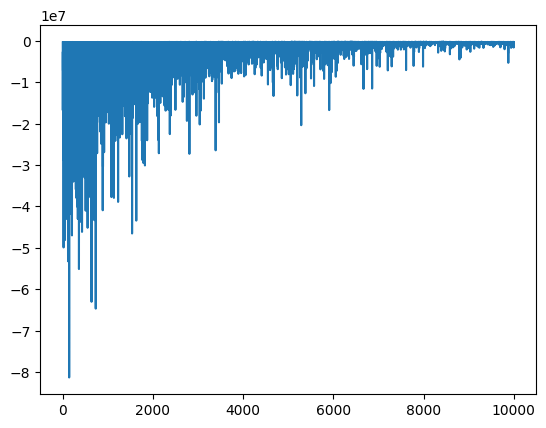

In [114]:
plt.plot(a)